### Defining the model imports

In [1]:
import tempfile
import zipfile
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
import os
import csv
import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')

### Listing model configuration

In [2]:
Input_Values = ["Collar_bone_x_","Collar_bone_y_","Collar_bone_z_","Upper_arm_x_","Upper_arm_y_","Upper_arm_z_","Fore_arm_x_","Fore_arm_y_","Fore_arm_z_","Hand_x_","Hand_y_","Hand_z_"]

Output_Values = ["Circular_Movements", "Straight_Movements"]

Train_Dataset_Path = ("Dataset/Training")
Test_Dataset_Path = ("Dataset/Testing")

In [3]:
n_hidden = 150 
n_classes = 2
learning_rate = 0.0025
lambda_loss_amount = 0.0015
batch_size = 100
display_iter = 30000 

### Loading and preparing the data

In [4]:
def load_X(X_feature_paths):
    X_features = []
    
    for feature_type_path in X_feature_paths:
        file = open(feature_type_path, 'r')
        with open(feature_type_path, 'r') as csvfile:
            reader = csv.reader(csvfile)
            X_features.append([np.array(row[0:61], dtype=np.float32) for row in reader])
    file.close()
    return np.transpose(np.array(X_features), (1, 2, 0)) #Permuting X_features array

def load_y(y_output_path):
    file = open(y_output_path, 'r')
    y_ = np.array(
        [element for element in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32)
    file.close()
    return y_

In [5]:
# Load dataset
Y_train_path =  (r"Dataset\\Training\Output_train.csv")
Y_test_path = (r"Dataset\\Testing\Output_test.csv")

Y_train = load_y(Y_train_path)
Y_test = load_y(Y_test_path)

X_train_feature_paths = [Train_Dataset_Path  +  "/Inputs/" + signal + "train.csv" for signal in Input_Values]
X_test_feature_paths = [Test_Dataset_Path + "/Inputs/" + signal + "test.csv" for signal in Input_Values]

X_train = load_X(X_train_feature_paths)
X_test = load_X(X_test_feature_paths)

training_data_count = len(X_train)
test_data_count = len(X_test) 
n_steps = len(X_train[0])  
n_input = len(X_train[0][0])  
training_iters = training_data_count * 300

print("Some useful info to get an insight on dataset's shape")
print("X shape -> {}, y shape -> {}".format(X_test.shape, Y_test.shape))

Some useful info to get an insight on dataset's shape
X shape -> (51, 61, 12), y shape -> (51, 1)


### Defining the model

In [6]:
def LSTM_RNN(_X, _weights, _biases):
    _X = tf.transpose(_X, [1, 0, 2])
    _X = tf.reshape(_X, [-1, n_input]) 
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    _X = tf.split(_X, n_steps, 0)
 
    lstm_feature_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_feature_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_feature_cells = tf.contrib.rnn.MultiRNNCell([lstm_feature_cell_1, lstm_feature_cell_2], state_is_tuple=True)
    
    outputs, states = tf.contrib.rnn.static_rnn(lstm_feature_cells, _X, dtype=tf.float32)
    lstm_last_output = outputs[-1]
    
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, step, batch_size): 
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_, n_classes=n_classes):
    y_ = y_.reshape(len(y_))
    return np.eye(n_classes)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

### Compiling the model

In [7]:
# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])),'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))}
biases = {'hidden': tf.Variable(tf.random_normal([n_hidden])),'out': tf.Variable(tf.random_normal([n_classes]))}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

W0617 00:08:46.064137 12888 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0617 00:08:46.074093 12888 deprecation.py:323] From <ipython-input-6-382f1738372e>:7: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0617 00:08:46.089081 12888 deprecation.py:323] From <ipython-input-6-382f1738372e>:9: MultiRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equ

In [8]:
def get_model():
    # Create a simple model.
    inputs = keras.Input(shape=(32,))
    outputs = keras.layers.Dense(1)(inputs)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model


model = get_model()

# Train the model.
test_input = np.random.random((128, 32))
test_target = np.random.random((128, 1))
model.fit(test_input, test_target)

# Calling `save('my_model')` creates a SavedModel folder `my_model`.
model.save("model")

# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("model")

# Let's check:
np.testing.assert_allclose(
    model.predict(test_input), reconstructed_model.predict(test_input)
)

# The reconstructed model is already compiled and has retained the optimizer
# state, so training can resume:
reconstructed_model.fit(test_input, test_target)

128/128 [==============================] - 4s 33ms/sample - loss: 1.8717


W0617 00:09:11.981516 12888 deprecation.py:506] From c:\users\hp\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


128/128 [==============================] - 0s 2ms/sample - loss: 1.7056


### Training and optimized model

In [9]:
# To keep track of training's performance
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []

# Launch the graph
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)

# Perform Training steps with "batch_size" amount of example data at each loop
step = 1
while step * batch_size <= training_iters:
    batch_xs =         extract_batch_size(X_train, step, batch_size)
    batch_ys = one_hot(extract_batch_size(Y_train, step, batch_size))

    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print("TRAINING MODEL #" + str(step*batch_size) + \
              ":   Batch Loss = " + "{:.5f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(Y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET: " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

TRAINING MODEL #100:   Batch Loss = 3.84571, Accuracy = 0.5600000023841858
PERFORMANCE ON TEST SET: Batch Loss = 9.7913818359375, Accuracy = 0.4901960790157318
TRAINING MODEL #30000:   Batch Loss = 1.46280, Accuracy = 0.9599999785423279
PERFORMANCE ON TEST SET: Batch Loss = 2.0683095455169678, Accuracy = 0.8235294222831726
Optimization Finished!


### Evaluating the model

In [10]:
# Accuracy for test data
one_hot_predictions, accuracy, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(Y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy))

FINAL RESULT: Batch Loss = 2.239588975906372, Accuracy = 0.7843137383460999


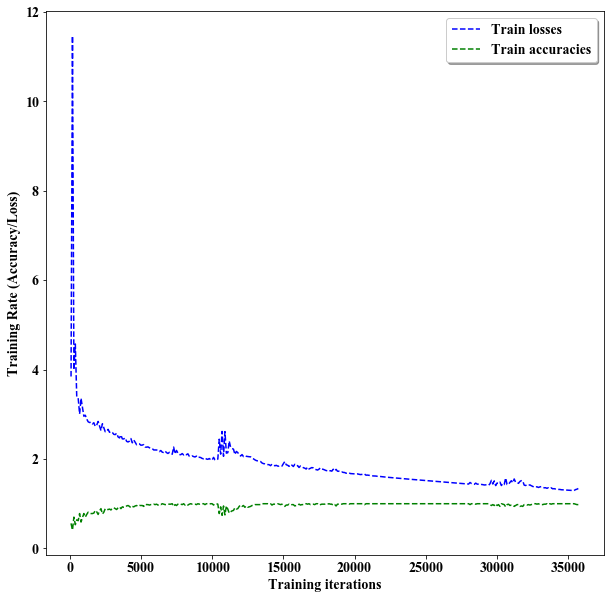

In [11]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Times New Roman',
    'weight' : 'bold',
    'size'   : 14
}
matplotlib.rc('font', **font)

width = 10
height = 10
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)

plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Rate (Accuracy/Loss)')
plt.xlabel('Training iterations')

plt.show()

In [12]:
predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("================================================")
print("Precision: {}%".format(100*metrics.precision_score(Y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(Y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(Y_test, predictions, average="weighted")))
print("Specificity: {}%".format(100*metrics.recall_score(Y_test,predictions,average='weighted')))
print("AUC Score: {}%".format(100*metrics.roc_auc_score(Y_test,predictions,average='weighted')))
print("================================================")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(Y_test, predictions)

print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("================================================")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)

Testing Accuracy: 78.43137383460999%
Precision: 78.45860566448802%
Recall: 78.43137254901961%
f1_score: 78.41476213126761%
Specificity: 78.43137254901961%
AUC Score: 78.38461538461539%
Confusion Matrix:
[[21  5]
 [ 6 19]]
Confusion matrix (normalised to % of total test data):
[[41.17647   9.803922]
 [11.764706 37.2549  ]]


### Model Evaluation Graph

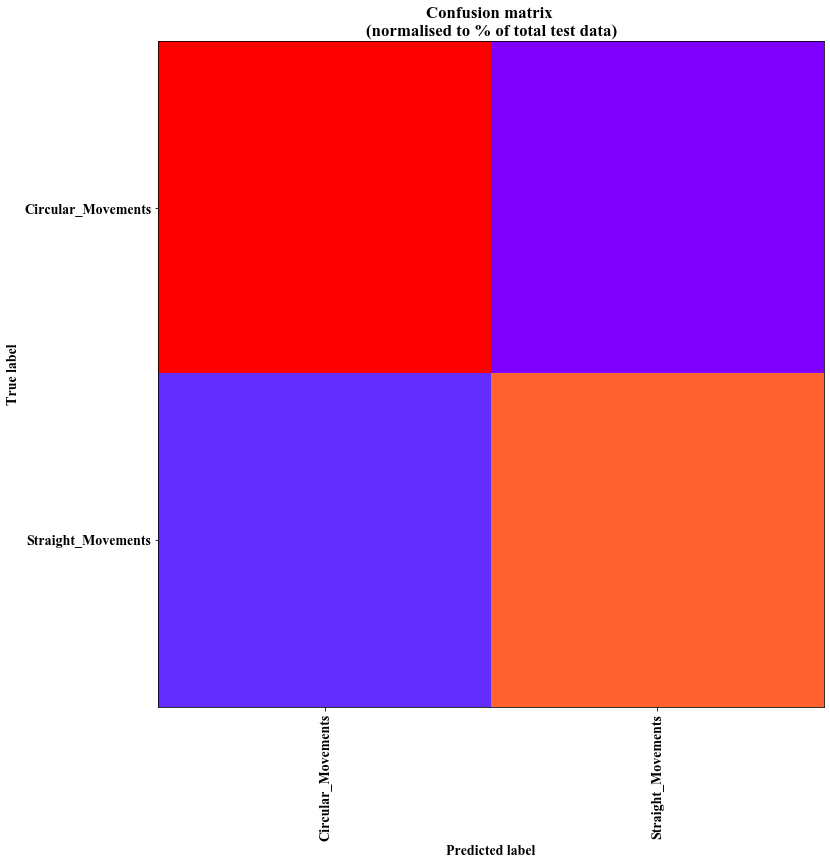

In [13]:
# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)

plt.title("Confusion matrix \n(normalised to % of total test data)")
#plt.colorbar()
tick_marks = np.arange(n_classes)

plt.xticks(tick_marks, Output_Values, rotation=90)

plt.yticks(tick_marks, Output_Values)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()